In [1]:
import numpy as np
import pandas as pd 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/segmented-66-image-dataset/dataset/images/043.png
/kaggle/input/segmented-66-image-dataset/dataset/images/069.png
/kaggle/input/segmented-66-image-dataset/dataset/images/074.png
/kaggle/input/segmented-66-image-dataset/dataset/images/027.png
/kaggle/input/segmented-66-image-dataset/dataset/images/007.png
/kaggle/input/segmented-66-image-dataset/dataset/images/089.png
/kaggle/input/segmented-66-image-dataset/dataset/images/023.png
/kaggle/input/segmented-66-image-dataset/dataset/images/092.png
/kaggle/input/segmented-66-image-dataset/dataset/images/016.png
/kaggle/input/segmented-66-image-dataset/dataset/images/005.png
/kaggle/input/segmented-66-image-dataset/dataset/images/013.png
/kaggle/input/segmented-66-image-dataset/dataset/images/046.png
/kaggle/input/segmented-66-image-dataset/dataset/images/042.png
/kaggle/input/segmented-66-image-dataset/dataset/images/024.png
/kaggle/input/segmented-66-image-dataset/dataset/images/057.png
/kaggle/input/segmented-66-image-dataset

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import os
import cv2
from glob import glob

import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D
from tensorflow.keras.layers import Conv2DTranspose, MaxPooling2D, concatenate, AveragePooling2D, Dense, Flatten
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import random
random.seed(3)

In [3]:
image_file = sorted(glob('../input/segmented-66-image-dataset/dataset/images/*.png'))
images = np.array([cv2.imread(path) for path in image_file])
images = np.array([cv2.resize(image, (256, 256)) for image in images])

mask_file = sorted(glob('../input/segmented-66-image-dataset/dataset/masks/*.png'))
masks = np.array([cv2.imread(path) for path in mask_file])
masks = np.array([cv2.resize(mask, (256, 256)) for mask in masks])

print(images.shape, masks.shape)

(66, 256, 256, 3) (66, 256, 256, 3)


In [4]:
def diagnosis(mask_path):
    value = np.max(cv2.imread(mask_path))
    return '1' if value > 0 else '0'
df = pd.DataFrame({"image_path": image_file,
                   "mask_path": mask_file,
                  "diagnosis":[diagnosis(mask) for mask in mask_file]})

print(len(df))
df.head()

66


,image_path,mask_path,diagnosis
0,../input/segmented-66-image-dataset/dataset/im...,../input/segmented-66-image-dataset/dataset/ma...,1
1,../input/segmented-66-image-dataset/dataset/im...,../input/segmented-66-image-dataset/dataset/ma...,1
2,../input/segmented-66-image-dataset/dataset/im...,../input/segmented-66-image-dataset/dataset/ma...,1
3,../input/segmented-66-image-dataset/dataset/im...,../input/segmented-66-image-dataset/dataset/ma...,1
4,../input/segmented-66-image-dataset/dataset/im...,../input/segmented-66-image-dataset/dataset/ma...,1


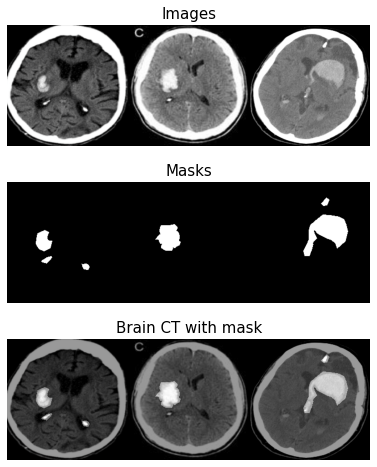

In [21]:
from mpl_toolkits.axes_grid1 import ImageGrid

df_positive = df[df['diagnosis']=='1'].sample(3).values

def show_data(df, positive=True):
    images = []
    masks = []
    for data in df:
        img = cv2.imread(data[0])
        mask = cv2.imread(data[1])
        images.append(img)
        masks.append(mask)
    images = np.hstack(np.array(images))
    masks = np.hstack(np.array(masks))
    
    fig = plt.figure(figsize=(8,8))
    if positive:
        grid = ImageGrid(fig, 111, nrows_ncols=(3,1), axes_pad=0.5)
    else:
        grid = ImageGrid(fig, 111, nrows_ncols=(2,1), axes_pad=0.5)
    grid[0].imshow(images)
    grid[0].set_title('Images', fontsize=15)
    grid[0].axis('off')
    grid[1].imshow(masks)
    grid[1].set_title('Masks', fontsize=15)
    grid[1].axis('off')
    if positive:
        grid[2].imshow(images)
        grid[2].imshow(masks, alpha=0.4)
        grid[2].set_title('Brain CT with mask', fontsize=15)
        grid[2].axis('off')
        
show_data(df_positive)

In [22]:
indicies = np.random.permutation(66)
train_true_idx, test_true_idx = indicies[:56], indicies[56:]

train_validation = pd.DataFrame(df.values[train_true_idx])
train_validation.columns =['image_path', 'mask_path', 'diagnosis']
test = pd.DataFrame(df.values[test_true_idx]) 
test.columns =['image_path', 'mask_path', 'diagnosis']

print(train_validation.shape, test.shape)

# train_validation.head()
# testX.head()

(56, 3) (10, 3)


In [23]:
# now to split train and validation sets
tr_len = train_validation.shape[0]
train_val_split = 48 #int(tr_len*0.85)
indicies = np.random.permutation(tr_len)
train_idx, validation_idx = indicies[:train_val_split], indicies[train_val_split:]

train = pd.DataFrame(train_validation.values[train_idx])
train.columns =['image_path', 'mask_path', 'diagnosis']
validation = pd.DataFrame(train_validation.values[validation_idx])
validation.columns =['image_path', 'mask_path', 'diagnosis']

print(train.shape, validation.shape)

# train.head()

(48, 3) (8, 3)


In [24]:
def train_generator(data_frame, batch_size, aug_dict,
        image_color_mode="rgb",
        mask_color_mode="grayscale",
        image_save_prefix="image",
        mask_save_prefix="mask",
        save_to_dir=None,
        target_size=(256,256),
        seed=1):

    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    
    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col = "image_path",
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col = "mask_path",
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)

    train_gen = zip(image_generator, mask_generator)
    
    for (img, mask) in train_gen:
        img, mask = adjust_data(img, mask)
        yield (img,mask)

def adjust_data(img,mask):
    img = img / 255.
    mask = mask / 255.
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    
    return (img, mask)

In [25]:
smooth=0.001

def dice_coef(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred)
    return (2.0 * intersection + smooth) / (union + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    return dice_coef_loss(y_true, y_pred) + bce(y_true, y_pred)

def iou(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

In [27]:
def unet(input_size=(256,256,3)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(64, (3, 3), padding='same')(inputs)
    bn1 = Activation('relu')(conv1)
    conv1 = Conv2D(64, (3, 3), padding='same')(bn1)
    bn1 = BatchNormalization(axis=3)(conv1)
    bn1 = Activation('relu')(bn1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(bn1)

    conv2 = Conv2D(128, (3, 3), padding='same')(pool1)
    bn2 = Activation('relu')(conv2)
    conv2 = Conv2D(128, (3, 3), padding='same')(bn2)
    bn2 = BatchNormalization(axis=3)(conv2)
    bn2 = Activation('relu')(bn2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(bn2)

    conv3 = Conv2D(256, (3, 3), padding='same')(pool2)
    bn3 = Activation('relu')(conv3)
    conv3 = Conv2D(256, (3, 3), padding='same')(bn3)
    bn3 = BatchNormalization(axis=3)(conv3)
    bn3 = Activation('relu')(bn3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(bn3)

    conv4 = Conv2D(512, (3, 3), padding='same')(pool3)
    bn4 = Activation('relu')(conv4)
    conv4 = Conv2D(512, (3, 3), padding='same')(bn4)
    bn4 = BatchNormalization(axis=3)(conv4)
    bn4 = Activation('relu')(bn4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(bn4)

    conv5 = Conv2D(1024, (3, 3), padding='same')(pool4)
    bn5 = Activation('relu')(conv5)
    conv5 = Conv2D(1024, (3, 3), padding='same')(bn5)
    bn5 = BatchNormalization(axis=3)(conv5)
    bn5 = Activation('relu')(bn5)

    up6 = concatenate([Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bn5), conv4], axis=3)
    conv6 = Conv2D(512, (3, 3), padding='same')(up6)
    bn6 = Activation('relu')(conv6)
    conv6 = Conv2D(512, (3, 3), padding='same')(bn6)
    bn6 = BatchNormalization(axis=3)(conv6)
    bn6 = Activation('relu')(bn6)

    up7 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(bn6), conv3], axis=3)
    conv7 = Conv2D(256, (3, 3), padding='same')(up7)
    bn7 = Activation('relu')(conv7)
    conv7 = Conv2D(256, (3, 3), padding='same')(bn7)
    bn7 = BatchNormalization(axis=3)(conv7)
    bn7 = Activation('relu')(bn7)

    up8 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(bn7), conv2], axis=3)
    conv8 = Conv2D(128, (3, 3), padding='same')(up8)
    bn8 = Activation('relu')(conv8)
    conv8 = Conv2D(128, (3, 3), padding='same')(bn8)
    bn8 = BatchNormalization(axis=3)(conv8)
    bn8 = Activation('relu')(bn8)

    up9 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(bn8), conv1], axis=3)
    conv9 = Conv2D(64, (3, 3), padding='same')(up9)
    bn9 = Activation('relu')(conv9)
    conv9 = Conv2D(64, (3, 3), padding='same')(bn9)
    bn9 = BatchNormalization(axis=3)(conv9)
    bn9 = Activation('relu')(bn9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(bn9)

    return Model(inputs=[inputs], outputs=[conv10])

model = unet()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 256, 256, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
activation_18 (Activation)      (None, 256, 256, 64) 0           conv2d_19[0][0]                  
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 256, 256, 64) 36928       activation_18[0][0]              
____________________________________________________________________________________________

In [28]:
# Set parameters
EPOCHS = 100
# BATCH_SIZE = 8
learning_rate = 1e-4

# Set parameters
IMAGE_SIZE = (256, 256)

In [29]:
import time

train_generator_args = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
#                             shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            vertical_flip=True,
                            fill_mode='nearest')
train_gen = train_generator(train, 8,
                                train_generator_args,
                                target_size=IMAGE_SIZE)
    
val_gen = train_generator(validation, 8,
                                dict(),
                                target_size=IMAGE_SIZE)

model = unet(input_size=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

opt = Adam(learning_rate = learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, amsgrad=False) #RMSprop(learning_rate=learning_rate)
model.compile(optimizer=opt, loss=bce_dice_loss, metrics=[iou, dice_coef, 'binary_accuracy'])

callbacks = [ModelCheckpoint('segmentation_model_v1.h5', verbose=0, save_best_only=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, min_lr=1e-11),
            EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=15)]

# train 48, validation 8, test 10
start = time.time()
history = model.fit(train_gen,
                    steps_per_epoch= 6, #len(train) / BATCH_SIZE, # batch size = 8
                    epochs=EPOCHS, 
                    callbacks=callbacks,
                    validation_data = val_gen,
                    validation_steps= 1 #len(validation) / BATCH_SIZE
                   )
stop = time.time()
print(f"Training time: {stop - start}s")

Found 48 validated image filenames.
Found 48 validated image filenames.


2022-03-17 16:08:48.402867: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


/opt/conda/lib/python3.7/site-packages/keras/backend.py:4994: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`binary_crossentropy` received `from_logits=True`, but the `output`'
2022-03-17 16:08:52.187191: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


6/6 [==============================] - ETA: 0s - loss: 1.4893 - iou: 0.0945 - dice_coef: 0.1723 - binary_accuracy: 0.6678Found 8 validated image filenames.
Found 8 validated image filenames.
6/6 [==============================] - 15s 465ms/step - loss: 1.4893 - iou: 0.0945 - dice_coef: 0.1723 - binary_accuracy: 0.6678 - val_loss: 1.5890 - val_iou: 0.0568 - val_dice_coef: 0.1074 - val_binary_accuracy: 0.2613
Epoch 2/100
6/6 [==============================] - 2s 310ms/step - loss: 1.2719 - iou: 0.1315 - dice_coef: 0.2321 - binary_accuracy: 0.8496 - val_loss: 1.5923 - val_iou: 0.0570 - val_dice_coef: 0.1079 - val_binary_accuracy: 0.2120
Epoch 3/100
6/6 [==============================] - 2s 305ms/step - loss: 1.0482 - iou: 0.1868 - dice_coef: 0.3126 - binary_accuracy: 0.9345 - val_loss: 1.6002 - val_iou: 0.0579 - val_dice_coef: 0.1094 - val_binary_accuracy: 0.2099
Epoch 4/100
6/6 [==============================] - 2s 319ms/step - loss: 0.8986 - iou: 0.2333 - dice_coef: 0.3755 - binary_accu

Text(0.5, 1.0, 'Dice Coef')

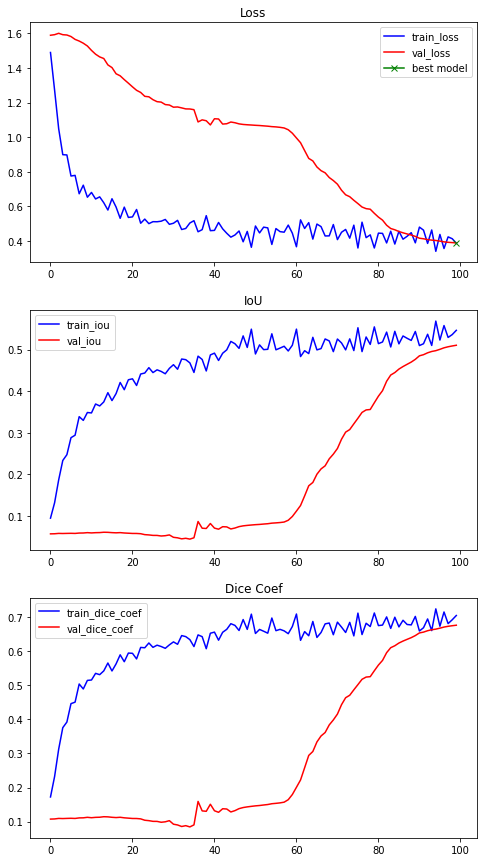

In [30]:
plt.figure(figsize=(8,15))
plt.subplot(3,1,1)
plt.plot(model.history.history['loss'], 'b-', label='train_loss')
plt.plot(model.history.history['val_loss'], 'r-', label='val_loss')
plt.plot( np.argmin(model.history.history["val_loss"]), np.min(model.history.history["val_loss"]), marker="x", color="g", label="best model")
plt.legend(loc='best')
plt.title('Loss')

plt.subplot(3,1,2)
plt.plot(model.history.history['iou'], 'b-', label='train_iou')
plt.plot(model.history.history['val_iou'], 'r-', label='val_iou')
plt.legend(loc='best')
plt.title('IoU')

plt.subplot(3,1,3)
plt.plot(model.history.history['dice_coef'], 'b-', label='train_dice_coef')
plt.plot(model.history.history['val_dice_coef'], 'r-', label='val_dice_coef')
plt.legend(loc='best')
plt.title('Dice Coef')

In [31]:
true = []
pred = []
iou_score = []
dice_score = []
s_iou = 0
s_dice = 0
for i in range(10):
    img = cv2.imread(test['image_path'].iloc[i])
    img = cv2.resize(img ,IMAGE_SIZE)
    img = img / 255
    img = img[np.newaxis, :, :, :]
    pred=model.predict(img)
    pred[pred>=0.5] = 1
    pred[pred<0.5] = 0
    
    mask = cv2.imread(test['mask_path'].iloc[i])
    gray = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    true = cv2.resize(gray ,IMAGE_SIZE)
    true = true / 255
    true = true[np.newaxis, :, :, np.newaxis]
    
    intersection_1 = np.sum(true * pred)
    sum_1 = np.sum(true + pred)
    iou_1 = (intersection_1 + 0.001) / (sum_1 - intersection_1 + 0.001)
    dice_1 = ((2*intersection_1) + 0.001) / (sum_1 + 0.001)
    iou_score.append(iou_1)
    dice_score.append(dice_1)
    s_iou += iou_1
    s_dice += dice_1
    print('intetsection %.5f'%intersection_1, 'union %.5f'%(sum_1 - intersection_1), 'sum %.5f'%sum_1, 'iou %.5f'%iou_1, 'dice %.5f'%dice_1)

print('%.5f'%(s_iou/10), '%.5f'%(s_dice/10))

intetsection 2791.69804 union 3310.13333 sum 6101.83137 iou 0.84338 dice 0.91504
intetsection 5845.96078 union 6909.75686 sum 12755.71765 iou 0.84604 dice 0.91660
intetsection 2740.26275 union 3497.47059 sum 6237.73333 iou 0.78350 dice 0.87861
intetsection 2235.98431 union 4834.50980 sum 7070.49412 iou 0.46250 dice 0.63248
intetsection 940.31373 union 1186.04314 sum 2126.35686 iou 0.79282 dice 0.88444
intetsection 4875.61569 union 5586.97647 sum 10462.59216 iou 0.87268 dice 0.93201
intetsection 2762.41569 union 3027.77255 sum 5790.18824 iou 0.91236 dice 0.95417
intetsection 2585.15294 union 3443.25882 sum 6028.41176 iou 0.75079 dice 0.85766
intetsection 5817.16863 union 6761.39216 sum 12578.56078 iou 0.86035 dice 0.92493
intetsection 5840.45098 union 6736.18431 sum 12576.63529 iou 0.86703 dice 0.92878
0.79914 0.88247


0


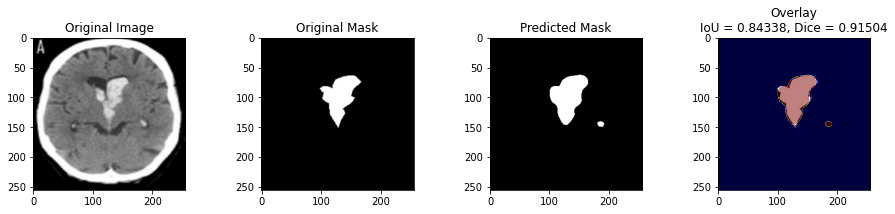

1


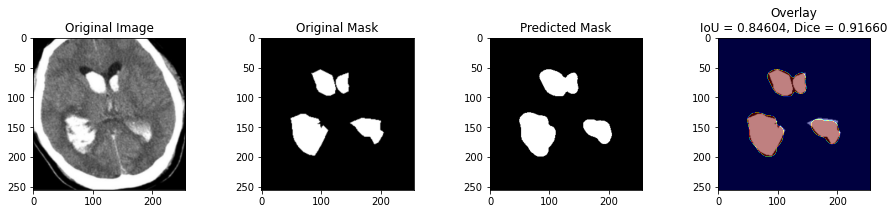

2


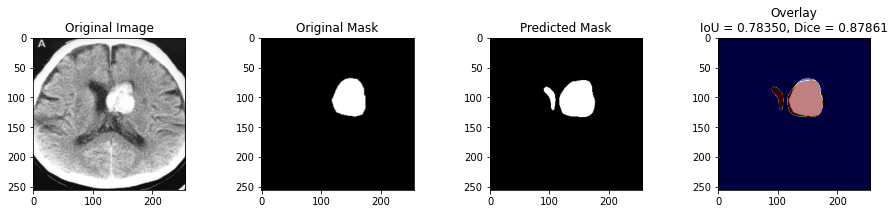

3


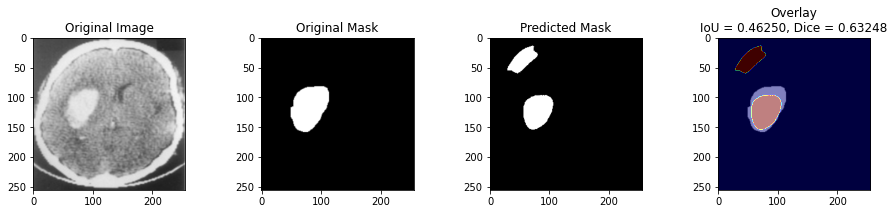

4


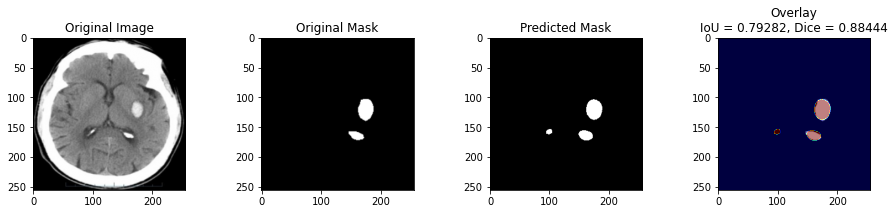

5


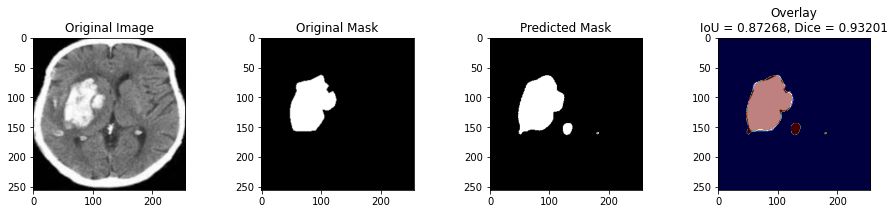

6


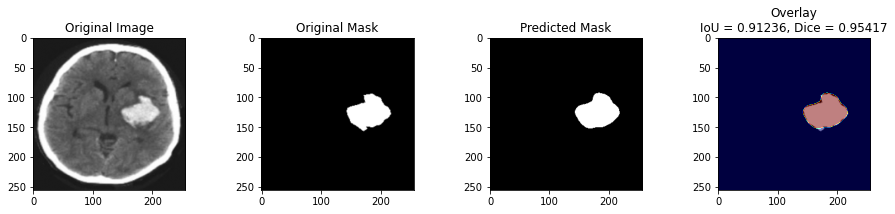

7


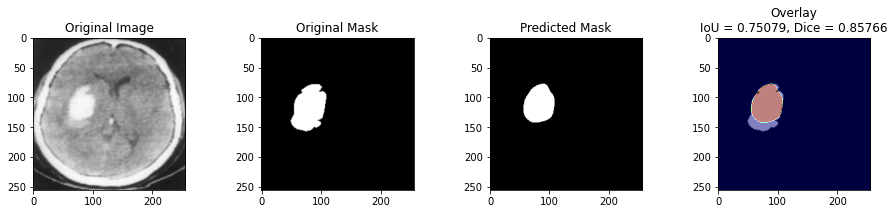

8


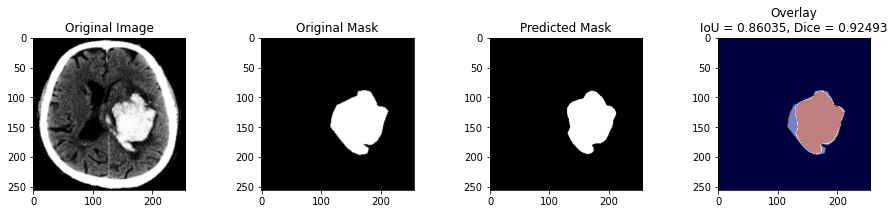

9


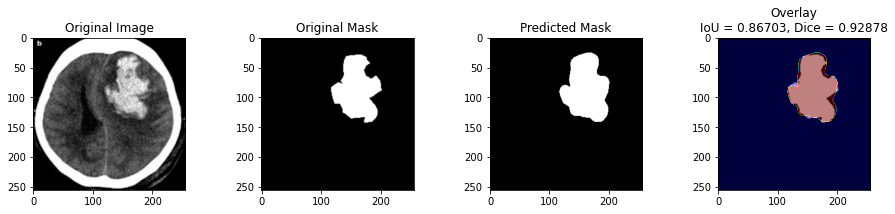

In [32]:
pred = []
true = []
for i in range(10):
    print(i)
    img = cv2.imread(test['image_path'].iloc[i])
    img = cv2.resize(img ,IMAGE_SIZE)
    img = img / 255
    img = img[np.newaxis, :, :, :]
    pred=model.predict(img)
    pred[pred>=0.5] = 1
    pred[pred<0.5] = 0
    
    plt.figure(figsize=(15,25))
    plt.subplot(1,4,1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')
    plt.subplot(1,4,2)
    plt.imshow(np.squeeze(cv2.resize((cv2.imread(test['mask_path'].iloc[i])), IMAGE_SIZE)))
    plt.title('Original Mask')
    plt.subplot(1,4,3)
    
    plt.imshow(np.squeeze(pred) > .5, cmap='gray')
    plt.title('Predicted Mask')
    plt.subplot(1,4,4)
    plt.imshow(np.squeeze(cv2.resize((cv2.imread(test['mask_path'].iloc[i])), IMAGE_SIZE)))
    plt.imshow(np.squeeze(pred) > .5, cmap='jet', alpha=.5)
    plt.title('Overlay\n' + 'IoU = %.5f'%iou_score[i] + ', Dice = %.5f'%dice_score[i])
    plt.subplots_adjust(wspace=0.5, hspace=0.8)
    plt.show()

In [33]:
import seaborn as sns
true_cnf = []
pred_cnf = []
FP = []
FN = []
TP = []
TN = []
for i in range(10):
    img = cv2.imread(test['image_path'].iloc[i])
    img = cv2.resize(img ,IMAGE_SIZE)
    img = img / 255
    img = img[np.newaxis, :, :, :]
    pred=model.predict(img)
    
    mask = cv2.imread(test['mask_path'].iloc[i])
    gray = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    true = cv2.resize(gray ,IMAGE_SIZE)
    true = true / 255
    true = true[np.newaxis, :, :, np.newaxis]

    pred[pred>0.5] = 1
    pred[pred<=0.5] = 0
    FP.append(len(np.where(pred - true  == -1)[0]))
    FN.append(len(np.where(pred - true  == 1)[0]))
    TP.append(len(np.where(pred + true ==2)[0]))
    TN.append(len(np.where(pred + true == 0)[0]))
    
    print("Image " + str(i) + ": " + "TP - " + str(TP[i]) + ", TN - " + str(TN[i]) + ", FP - " + 
          str(FP[i]) + ", FN - " + str(FN[i]))

Image 0: TP - 2649, TN - 62182, FP - 22, FN - 299
Image 1: TP - 5490, TN - 58517, FP - 117, FN - 541
Image 2: TP - 2643, TN - 61980, FP - 77, FN - 561
Image 3: TP - 2235, TN - 60562, FP - 1228, FN - 1203
Image 4: TP - 887, TN - 64275, FP - 29, FN - 121
Image 5: TP - 4727, TN - 59872, FP - 74, FN - 453
Image 6: TP - 2641, TN - 62453, FP - 23, FN - 96
Image 7: TP - 2531, TN - 61951, FP - 688, FN - 11
Image 8: TP - 5770, TN - 58557, FP - 732, FN - 7
Image 9: TP - 5647, TN - 58725, FP - 90, FN - 571


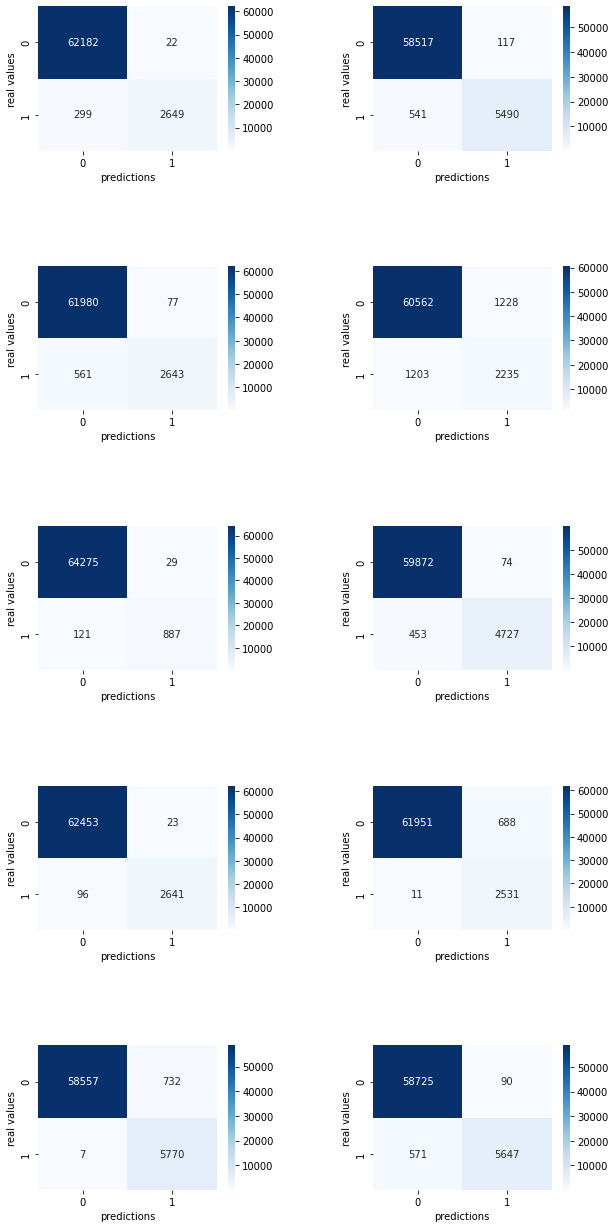

In [36]:
rows = 13
plt.figure(figsize=(10, 60))
for i in range(10):
    plt.subplot(rows, 2, i+1)
    cmat = [[TN[i], FP[i]],[FN[i], TP[i]]]
    sns.heatmap(cmat, cmap="Blues", annot=True, fmt = 'g')
    plt.xlabel("predictions")
    plt.ylabel("real values")
    plt.subplots_adjust(wspace=0.5, hspace=0.8)

plt.show()